---
# Overlap 2D-EPI pRFs & line-scanning pRFs

In [5]:
%matplotlib inline

In [13]:
from linescanning import (
    prf,
    utils,
    plotting
)
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pRFline.fitting import pRFResults
opj = os.path.join

In [3]:
def normalize_prf(src,targ):

    norm = targ.copy()
    norm[0] -= src[0]
    norm[1] -= src[1]
    norm[2] /= src[2]

    return norm


---------------------------------------------------------------------------------------------------
Dealing with sub-001
Loading in files:
 pRF params:    /data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/prf/sub-001/ses-2/sub-001_ses-2_task-pRF_run-avg_vox-avg_model-gauss_stage-iter_desc-prf_params.pkl
 Design matrix: /data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/prf/sub-001/ses-2/sub-001_ses-2_task-pRF_run-avg_desc-design_matrix.mat
 fMRI data:     /data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/prf/sub-001/ses-2/sub-001_ses-2_task-pRF_run-avg_vox-avg_desc-data.npy
Reading settings from '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/code/prf_analysis.yml'
Instantiate HRF with: [1, 1, 0]
HRF: [1, 1, 0]
Reading settings from pickle-file (safest option; overwrites other settings)
Inserting parameters from <class 'str'> as 'gauss_iter' in <linescanning.prf.pRFmodelFitting object at 0x7f0f789e3910>
Reading /data1/projects/MicroFunc/Jurjen/project

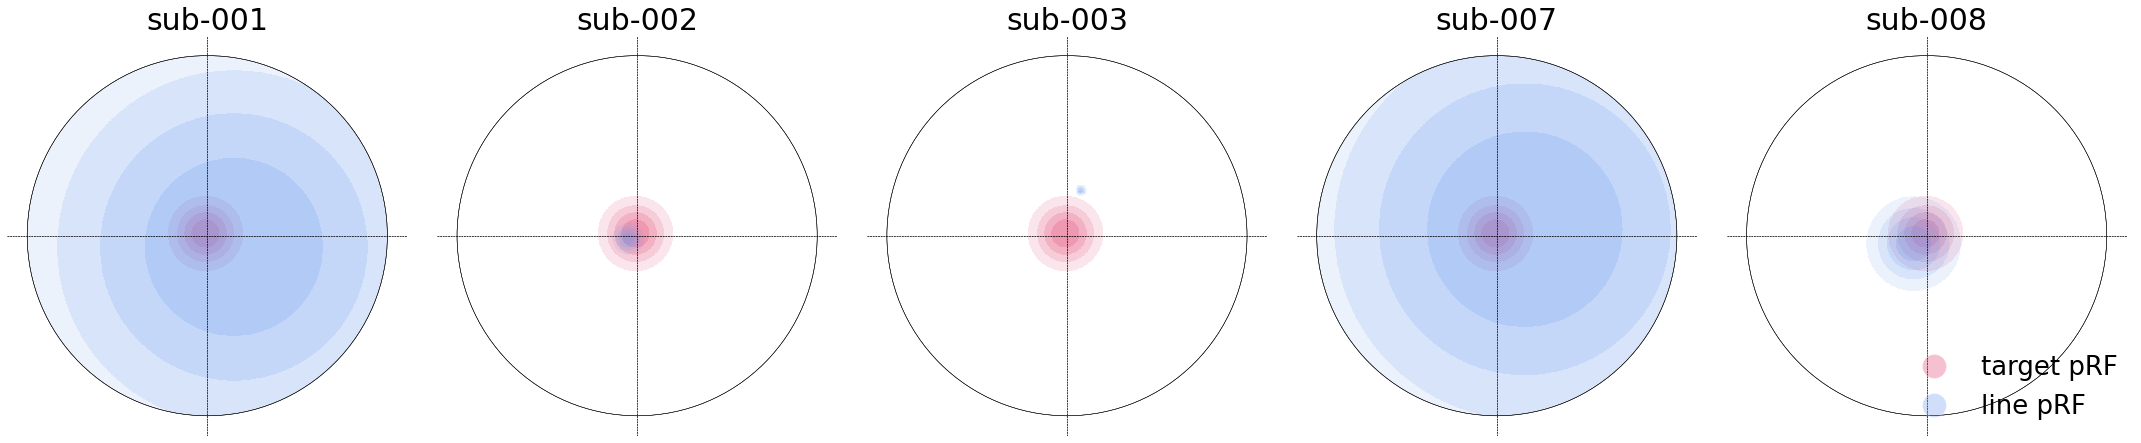

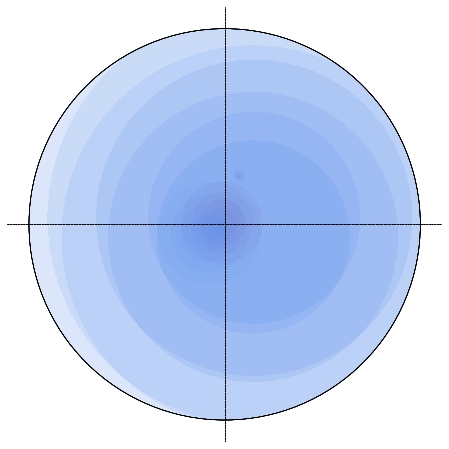

In [19]:
# set paths
project_dir = os.environ.get("DIR_PROJECTS")
base_dir    = os.path.join(project_dir, 'VE-pRF')
deriv_dir   = opj(base_dir, 'derivatives')

# set defaults
sub_list = ["001","002","003","007","008"]
model = "gauss"

colors = ["#DE3163", "#6495ED"]
cmap1 = utils.make_binary_cm(colors[0])
cmap2 = utils.make_binary_cm(colors[1])

fig2 = plt.figure(figsize=(len(sub_list)*6,6))
gs = fig2.add_gridspec(1,len(sub_list))

for ix,sub in enumerate(sub_list):

    # get parameters
    prf_new = opj(deriv_dir, 'prf', f"sub-{sub}", "ses-2")
    search_for = [f"model-{model}", "stage-iter", "vox-avg", f"params.pkl"]
    pars = utils.get_file_from_substring(search_for, prf_new, exclude="hrf")

    print("\n---------------------------------------------------------------------------------------------------")
    print(f"Dealing with sub-{sub}")

    # get voxel-specific data
    results = pRFResults(pars, verbose=True)
    vx_data = results.plot_prf_timecourse(
        vox_nr=0, 
        make_figure=False, 
        overlap=False)      

    if ix == 0:
        n_epi_prf = prf.make_prf(
            results.target_obj.prf_stim, 
            mu_x=0,
            mu_y=0,
            size=1,
            resize_pix=270
        )

        fig,axs = plt.subplots(figsize=(8,8))
        plotting.LazyPRF(
            n_epi_prf, 
            [-5,5],
            ax=axs,
            cmap=cmap1,
            cross_color="k",
            shrink_factor=0.9,
            alpha=0.5)

    # plot normalized pRF
    n_line_pars = normalize_prf(results.target['pars'],vx_data[0][0])
    n_line_prf = prf.make_prf(
        results.target_obj.prf_stim, 
        mu_x=n_line_pars[0],
        mu_y=n_line_pars[1],
        size=n_line_pars[2],
        resize_pix=270
    )

    plotting.LazyPRF(
        n_line_prf, 
        [-5,5],
        ax=axs,
        cmap=cmap2,
        cross_color="k",
        shrink_factor=0.9,
        alpha=0.5)

    # get distance of pRF-centers
    # dist = prf.distance_centers(n_epi_prf, n_line_prf)

    # initiate and plot figure
    ax2 = fig2.add_subplot(gs[ix])
    for ix2, obj in enumerate([n_epi_prf,n_line_prf]):
        plotting.LazyPRF(
            obj, 
            vf_extent=[-5,5], 
            ax=ax2, 
            cmap=[cmap1,cmap2][ix2], 
            cross_color='k', 
            alpha=0.5, 
            title=f"sub-{sub}", #: {round(dist, 2)} dva",
            font_size=30,
            shrink_factor=0.9)


# create custom legend
legend_elements = [
    Line2D([0],[0], marker='o', color='w', label='target pRF', mfc=colors[0], markersize=24, alpha=0.3),
    Line2D([0],[0], marker='o', color='w', label='line pRF', mfc=colors[1], markersize=24, alpha=0.3)]

L = fig2.legend(handles=legend_elements, frameon=False, fontsize=26, loc='lower right')
plt.setp(L.texts, family='Arial')
fig2.tight_layout()

fig.savefig("/data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/results/normalized_prf_1plot.svg", bbox_inches="tight", dpi=300)
fig2.savefig("/data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/results/normalized_prf_splitplot.svg", bbox_inches="tight", dpi=300)